In [30]:
import pymc as pm
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import pyei as pyei
import matplotlib.pyplot as plt
from pymc import sampling_jax

In [3]:
# Example 2x2 data
data = pd.read_csv("../data/demographics_with_race.csv", index_col = 0)
data

,pop,race_w,race_b,hhinc,incpercap,incpov_2_,incpov__2,init_count_pre,init_day_pre,tot_count_pre,tot_day_pre,init_p_pre,init_count_covid,init_day_covid,tot_count_covid,tot_day_covid,init_p_covid
0,478,97.07,0.00,83667,73312,90.17,9.83,2815,7.019950,3889,9.698254,72.383646,482,2.190909,945,4.295455,51.005291
1,1212,85.23,4.04,77604,42620,77.56,22.44,2161,5.389027,3192,7.960100,67.700501,782,3.554545,1373,6.240909,56.955572
2,2109,71.12,7.02,105913,21587,89.16,10.84,1524,3.800499,1932,4.817955,78.881988,63,0.286364,231,1.050000,27.272727
3,676,83.14,0.00,66944,35319,68.20,31.80,174,0.433915,380,0.947631,45.789474,14,0.063636,79,0.359091,17.721519
4,1137,64.56,9.59,55167,14173,65.80,34.20,555,1.384040,961,2.396509,57.752341,12,0.054545,207,0.940909,5.797101
5,1044,81.80,4.69,116875,43521,82.38,17.62,1285,3.204489,1861,4.640898,69.048898,355,1.613636,628,2.854545,56.528662
6,858,92.66,2.45,81875,39540,85.05,14.95,2149,5.359102,2880,7.182045,74.618056,830,3.772727,1206,5.481818,68.822554


In [4]:
# Proportion of white residents by CBG.
X_race = np.array((data["race_w"]/100))
X_race

# Number of white residents by CBG.
num_white = X_race * data["pop"].values
num_white

# Proportion of non-white residents by CBG.
1-X_race

# Number of non-white residents by CBG.
num_non_white = (1-X_race)*data["pop"].values
num_non_white

# Number of calls by CBG
C = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
C

# Number of people by CBG
p = data["pop"].values
p

array([ 478, 1212, 2109,  676, 1137, 1044,  858])

In [5]:
# Proportion of non low income residents by CBG.
X_pov = 1 - np.array((data["incpov__2"]/100))

# Number of non-low income residents by CBG.
num_non_low_inc = X_pov*data["pop"].values.round()
num_non_low_inc

# Number of non low-income residents by CBG.
num_low_inc = p - num_non_low_inc


In [6]:
C/p

array([2.24686192, 0.85066007, 0.19345661, 0.30473373, 0.35708004,
       0.55172414, 0.85198135])

## Set up and fit the model

In [7]:
num_precincts = len(p)
def fit_model2(num_gp1, num_gp2):
    with pm.Model() as model:

        mu_1 =    pm.HalfCauchy("mu_1", 1)
        mu_2 =    pm.HalfCauchy("mu_2", 1) 
       
        sigma_1 = pm.Gamma("sigma_1", mu=4, sigma = 8 ** 0.5)
        sigma_2 = pm.Gamma("sigma_2", mu=4, sigma = 8 ** 0.5)

        b_1 = pm.TruncatedNormal("b_1", mu=mu_1, sigma=sigma_1, lower=0, shape=num_precincts)
        b_2 = pm.TruncatedNormal("b_2", mu=mu_2, sigma=sigma_2, lower=0, shape=num_precincts)

        theta = num_gp1 * b_1 + num_gp2 * b_2

        pm.Poisson("calls_for_service", mu=theta, observed=C)

        sim_trace = pm.sample(
            draws=2000,
            chains=4,
            tune=2000,
            target_accept = .995
            )
        
        return sim_trace

sim_trace_model2 = fit_model2(num_white, num_non_white)
sim_trace_model2_inc = fit_model2(num_low_inc, num_non_low_inc)

   

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/Users/annahaensch/miniconda3/envs/my_env/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_1, mu_2, sigma_1, sigma_2, b_1, b_2]
INFO:pymc:NUTS: [mu_1, mu_2, sigma_1, sigma_2, b_1, b_2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1059 seconds.
INFO:pymc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1059 seconds.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/Users/annahaensch/miniconda3/envs/my_env/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
I

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 869 seconds.
INFO:pymc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 869 seconds.


## Inspect traces, visualize some priors

array([[<AxesSubplot: title={'center': 'mu_1'}>,
        <AxesSubplot: title={'center': 'mu_1'}>],
       [<AxesSubplot: title={'center': 'mu_2'}>,
        <AxesSubplot: title={'center': 'mu_2'}>],
       [<AxesSubplot: title={'center': 'sigma_1'}>,
        <AxesSubplot: title={'center': 'sigma_1'}>],
       [<AxesSubplot: title={'center': 'sigma_2'}>,
        <AxesSubplot: title={'center': 'sigma_2'}>],
       [<AxesSubplot: title={'center': 'b_1'}>,
        <AxesSubplot: title={'center': 'b_1'}>],
       [<AxesSubplot: title={'center': 'b_2'}>,
        <AxesSubplot: title={'center': 'b_2'}>]], dtype=object)

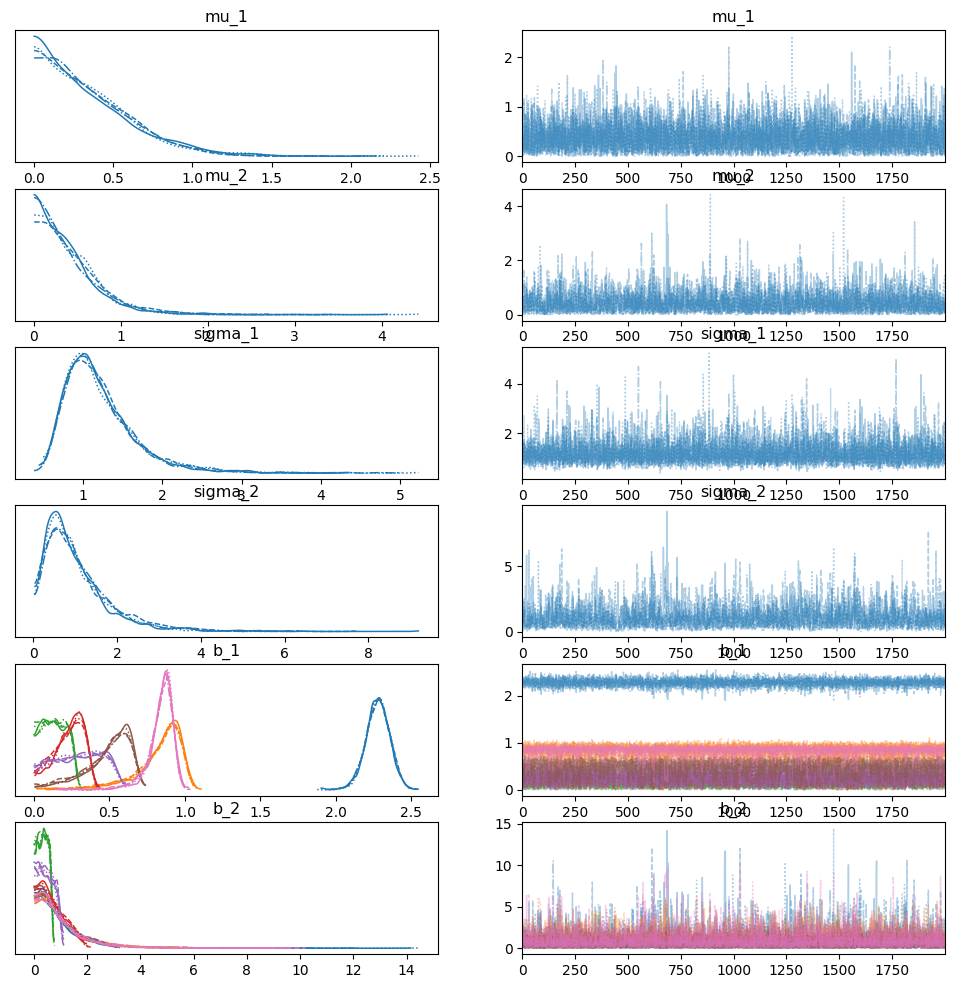

In [8]:
import arviz as az
az.plot_trace(sim_trace_model2)

Text(0.5, 1.0, 'prior for sigma_g, sigma_1')

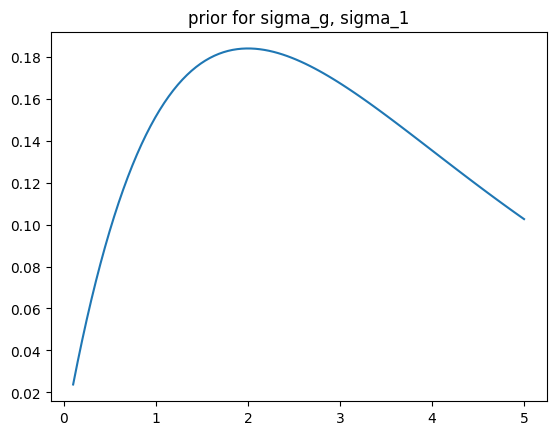

In [9]:
# visualize the hyperpriors
sigma_test = np.linspace(0.1,5,100)

m_1 = 4
s_1 = 8 ** 0.5
sigma_1 = pm.Gamma.dist(mu=m_1, sigma=s_1)
sigma_logp = pm.logp(sigma_1, sigma_test).eval()

plt.plot(sigma_test, np.exp(sigma_logp))
plt.title("prior for sigma_g, sigma_1")

Text(0.5, 1.0, 'mu prior')

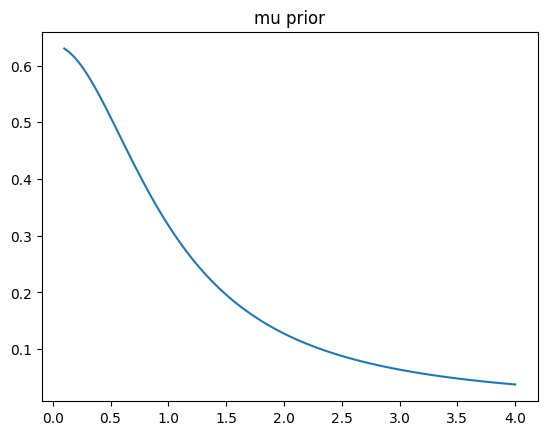

In [10]:
mu_test = np.linspace(0.1, 4, 100)
mu_1 = pm.HalfCauchy.dist(1)
mu_1_logp = pm.logp(mu_1, mu_test).eval()
plt.plot(mu_test, np.exp(mu_1_logp))
plt.title("mu prior")

Text(0.5, 1.0, 'b_1 | mu=2, sigma=2')

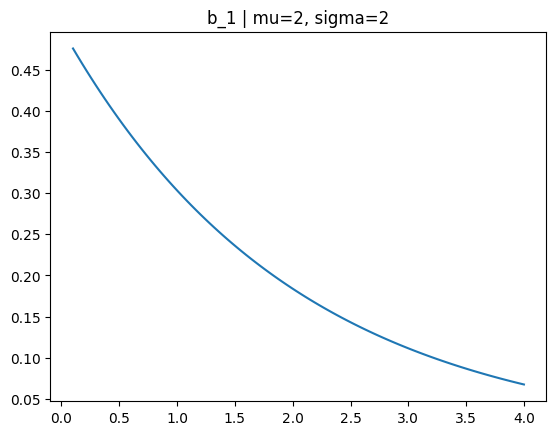

In [11]:
mu_1 = 2
sigma_1 = 2
b_1 = pm.Gamma.dist(mu=mu_1, sigma=sigma_1)
b_1_logp = pm.logp(b_1, mu_test).eval()

plt.plot(mu_test, np.exp(b_1_logp))
plt.title(f"b_1 | mu={mu_1}, sigma={sigma_1}")

### Create and save plots

### Block-group level plot

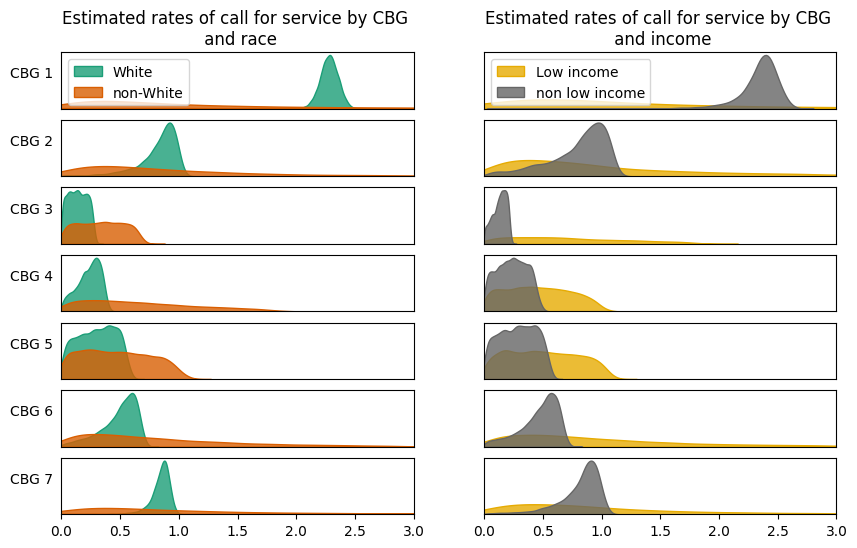

In [13]:
# View estimated call-for-service rates by block group
import matplotlib as mpl
cmap = mpl.cm.get_cmap('Dark2')
color0 = cmap(0)
color1 = cmap(1)
color2 = cmap(5)
color3 = cmap(7)
kde_alpha=0.8

import seaborn as sns
percentiles = [2.5, 97.5]
b_1 = sim_trace_model2["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values
b_2 = sim_trace_model2["posterior"]["b_2"].stack(all_draws=["chain", "draw"]).values

b_1_inc = sim_trace_model2_inc["posterior"]["b_1"].stack(all_draws=["chain", "draw"]).values
b_2_inc = sim_trace_model2_inc["posterior"]["b_2"].stack(all_draws=["chain", "draw"]).values


fig, axes = plt.subplots(num_precincts, 2, figsize=(10,6))
for i in range(num_precincts):
    ax = axes[i,0]
    sns.kdeplot(b_1[i],ax=ax, fill=True,label="White", color=color0, alpha=kde_alpha)
    sns.kdeplot(b_2[i],ax=ax, fill=True, label="non-White",color=color1, alpha=kde_alpha)
    ax.set_xlim((0,3))
    ax.set_ylabel(f"CBG {i+1}",rotation=0, labelpad=18)
    ax.set_yticks([])
    if i != num_precincts-1:
        ax.set_xticks([])
       
        
    ax = axes[i,1]
    sns.kdeplot(b_1_inc[i],ax=ax, fill=True,label="Low income", color=color2, alpha=kde_alpha)
    sns.kdeplot(b_2_inc[i],ax=ax, fill=True, label="non low income",color=color3, alpha=kde_alpha)
    ax.set_xlim((0,3))
    ax.set_yticks([])
    ax.set_ylabel("")


    if i != num_precincts-1:
        ax.set_xticks([])
        
axes[0,0].set_title("Estimated rates of call for service by CBG \n and race")
axes[0,1].set_title("Estimated rates of call for service by CBG \n and income")
axes[0,0].legend(loc='upper left')
axes[0,1].legend(loc='upper left')
fig.savefig("CBG_rate_ests.png", bbox_inches='tight')

plt.show()

In [14]:
p

array([ 478, 1212, 2109,  676, 1137, 1044,  858])

In [15]:
num_white / p

array([0.9707, 0.8523, 0.7112, 0.8314, 0.6456, 0.818 , 0.9266])

### Aggregated plot

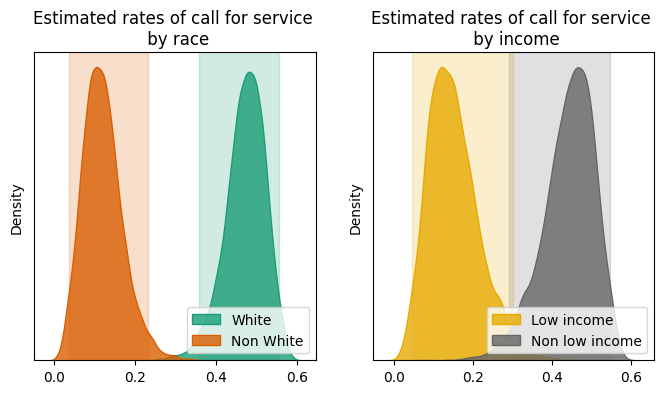

White: 0.47062543844588084, [0.35809911 0.55391773] 
non-White: 0.1197996781319341, [0.03793189 0.2318354 ] 
Low income: 0.15021740218922924, [0.04589444 0.29992269] 
non-low income: 0.44011190660967464, [0.29054208 0.54543154] 


In [16]:
call_rate_white_aggregated = (b_1.T * num_white ).sum(axis=1) / p.sum() # samples
call_rate_non_white_aggregated = (b_2.T * num_non_white).sum(axis=1) / p.sum() #samples

call_rate_low_inc_aggregated = (b_1_inc.T * num_low_inc ).sum(axis=1) / p.sum() # samples
call_rate_non_low_inc_aggregated = (b_2_inc.T * num_non_low_inc).sum(axis=1) / p.sum() #samples


fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]
sns.kdeplot(call_rate_white_aggregated,ax=ax, fill=True,label="White", color=color0, alpha=kde_alpha)
sns.kdeplot(call_rate_non_white_aggregated, ax=ax, fill=True, label="Non White", color=color1, alpha=kde_alpha)
ax.set_yticks([])
ax.axvspan(np.percentile(call_rate_white_aggregated, percentiles)[0], np.percentile(call_rate_white_aggregated, percentiles)[1], color= color0, alpha = .2, zorder = 0)
ax.axvspan(np.percentile(call_rate_non_white_aggregated, percentiles)[0], np.percentile(call_rate_non_white_aggregated, percentiles)[1], color= color1, alpha = .2, zorder = 0)


ax.set_title("Estimated rates of call for service \n by race")
ax.legend(loc='lower right')

ax = axes[1]
sns.kdeplot(call_rate_low_inc_aggregated,ax=ax, fill=True,label="Low income", color=color2, alpha=kde_alpha)
sns.kdeplot(call_rate_non_low_inc_aggregated, ax=ax, fill=True, label="Non low income", color=color3, alpha=kde_alpha)
ax.set_yticks([])
ax.set_title("Estimated rates of call for service \n by income")
ax.legend(loc='lower right')
ax.axvspan(np.percentile(call_rate_low_inc_aggregated, percentiles)[0], np.percentile(call_rate_low_inc_aggregated, percentiles)[1], color= color2, alpha = .2, zorder = 0)
ax.axvspan(np.percentile(call_rate_non_low_inc_aggregated, percentiles)[0], np.percentile(call_rate_non_low_inc_aggregated, percentiles)[1], color= color3, alpha = .2, zorder = 0)

fig.savefig("Aggregated_rate_ests.png", bbox_inches='tight')
plt.show()

print(f"White: {call_rate_white_aggregated.mean()}, {np.percentile(call_rate_white_aggregated, percentiles)} ")
print(f"non-White: {call_rate_non_white_aggregated.mean()}, {np.percentile(call_rate_non_white_aggregated, percentiles)} ")
print(f"Low income: {call_rate_low_inc_aggregated.mean()}, {np.percentile(call_rate_low_inc_aggregated, percentiles)} ")
print(f"non-low income: {call_rate_non_low_inc_aggregated.mean()}, {np.percentile(call_rate_non_low_inc_aggregated, percentiles)} ")



# The Goodman's Regression Problem
We propose to solve the following regression equation

$$
C_i = r_g \cdot p_i \cdot X_i + r_0 \cdot p_i \cdot (1-X_i)
$$

where $C_i$ is the number of calls for service in CBG$_i$, $p_i$ is the population of CBG$_i$, and $X_i$ is the proportion of residents from demographic group $g$ in CBG $i$. In this model, we are solving the for coefficients $r_g$, the _in-group rate of calls for service_ and $r_0$, the _out-group rate of calls for service_.  Before solving, we will normalize the equation as follows,

$$
\frac{C_i}{p_i\cdot m} =  \frac{r_g}{m} \cdot X_i + \frac{r_0}{m} \cdot (1-X_i)
$$

for a normalizing contstant $m$ defined below.  Then using the tools of PyEi we can solve 

$$
Y_i = \beta^g \cdot X_i + \beta^0 \cdot (1- X_i)
$$
in the usual way, where 

\begin{eqnarray*}
Y_i =  \frac{C_i}{p_i\cdot m}\,\,\,\text{ and }\,\,\,
\beta^g & = & \frac{r_g}{m}\,\,\,\text{ and }\,\,\,
\beta^0 & = & \frac{r_0}{m}.
\end{eqnarray*}


In [17]:
# Number of calls by CBG
C = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
C

array([1074, 1031,  408,  206,  406,  576,  731])

In [18]:
# Number of people by CBG
p = data["pop"].values
p

array([ 478, 1212, 2109,  676, 1137, 1044,  858])

## Analysis by Race

We will first example white and non-white citizen cohorts.

In [19]:
# Proportion of white residents by CBG.
X_race = np.array((data["race_w"]/100))
X_race

array([0.9707, 0.8523, 0.7112, 0.8314, 0.6456, 0.818 , 0.9266])

In [20]:
# Number of white residents by CBG.
num_white = X_race * data["pop"].values
num_white

array([ 463.9946, 1032.9876, 1499.9208,  562.0264,  734.0472,  853.992 ,
        795.0228])

In [21]:
# Proportion of non-white residents by CBG.
1-X_race

array([0.0293, 0.1477, 0.2888, 0.1686, 0.3544, 0.182 , 0.0734])

In [22]:
# Number of non-white residents by CBG.
num_non_white = (1-X_race)*data["pop"].values
num_non_white

array([ 14.0054, 179.0124, 609.0792, 113.9736, 402.9528, 190.008 ,
        62.9772])

In [23]:
# # Normalizing Constant
max_calls = max(C)
min_pop = min(np.concatenate([num_white, num_non_white]))
m_race = max_calls / min_pop
m_race

76.68470732717353

In [24]:
# Normalized call rate by CBG
Y_race = (m_race ** -1) * np.array(C / data["pop"])
Y_race

array([0.0293    , 0.01109296, 0.00252275, 0.00397385, 0.00465647,
       0.00719471, 0.01111019])

In [25]:
demographic_group_name = "white"
demographic_group_name 

'white'

In [26]:
precinct_pops = np.array(data["pop"])
demographic_group_name = "white"
candidate_name = "Calls for Service"
precinct_names = list(data.index)

In [27]:
# # Fitting a first 2 x 2 model

# # Create a TwobyTwoEI object
# ei_race = pyei.TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=15, pareto_shape=2)

# # Fit the model
# ei_race.fit(group_fraction = X_race, 
#        votes_fraction = Y_race, 
#        precinct_pops = precinct_pops, 
#        demographic_group_name=demographic_group_name , 
#        candidate_name=candidate_name, 
#        precinct_names=precinct_names, 
#        draws=1200, # optional
#        tune=3000, # optional
#        target_accept=.99# optional
# )

# # Generate a simple report to summarize the results
# print(ei_race.summary())

In [28]:
# means = np.array(ei_race.posterior_mean_voting_prefs) * m_race
# cred_int = np.array(ei_race.credible_interval_95_mean_voting_prefs) * m_race

# m = np.around(means[0], decimals = 2)
# c = [np.around(i, decimals = 2) for i in cred_int[0]]
# print(f"The posterior mean belief for white is {m} with 95% credible interval {c}.")

# m = np.around(means[1], decimals = 2)
# c = [np.around(i, decimals = 2) for i in cred_int[1]]
# print("")
# print(f"The posterior mean belief for non-white is {m} with 95% credible interval {c}.")

In [31]:
# Fitting Goodman's ER - precincts weighted by population
race_goodmans_er = pyei.GoodmansER(is_weighted_regression="True")

race_goodmans_er.fit(group_fraction = X_race, 
    vote_fraction = Y_race,
    precinct_pops = precinct_pops, # Must include populations if weighting by population
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name
)

print(race_goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of white
        voters who voted for Calls for Service is
        0.018
        Est. fraction of non- white
        voters who voted for Calls for Service is
        -0.032
        


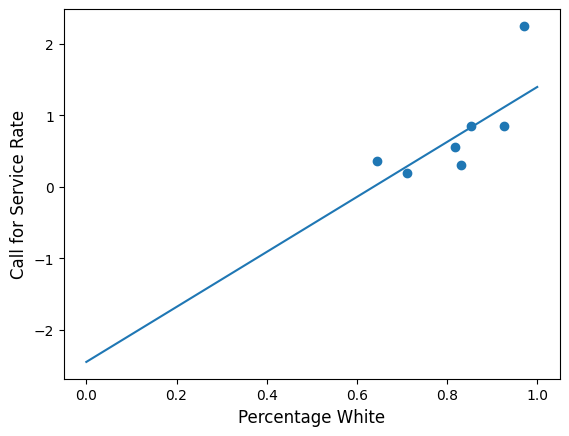

In [32]:
race_slope = m_race * float(race_goodmans_er.slope_)
race_intercept = m_race * float(race_goodmans_er.intercept_)

fig, ax = plt.subplots()
ax.scatter(X_race,Y_race * m_race)
plt.plot([0,1],[race_intercept, race_slope + race_intercept])

ax.set_ylabel("Call for Service Rate", fontsize = 12)
ax.set_xlabel("Percentage White", fontsize = 12)

plt.show()

In [34]:
# bayes_goodman_ei = pyei.GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)

# bayes_goodman_ei.fit(
#     group_fraction = X_race, 
#     votes_fraction = Y_race,
#     precinct_pops = precinct_pops,
#     demographic_group_name=demographic_group_name, 
#     candidate_name=candidate_name
# )


In [35]:
# ei_race.plot_kde()

In [36]:
# ei_race.plot_polarization_kde(percentile=95, show_threshold=True)

## Analysis by Income Level

They do, however, have the ratio of income to poverty level. Many programs use income as a percent of poverty level as a threshold, like 130% for SNAP and 200% for others like prioritized childcare, so I included the percent of people living above 200% (`incpov_2_`) and below 200% (`incpov__2`). Note that the number of people for whom this data is available is a lot lower than the total number of people in the CBGS for the school (the attached Excel sheet has the raw data on these), so it might not capture the entire population. I’ve also included the per capita income (`incpercap`) from the Census, should you decide to use that instead. The federal poverty line is evidently outdated, and many programs and states now use a relative % of median income for the state/area, but I haven’t found that data from the Census.  

In [37]:
data.head()

,pop,race_w,race_b,hhinc,incpercap,incpov_2_,incpov__2,init_count_pre,init_day_pre,tot_count_pre,tot_day_pre,init_p_pre,init_count_covid,init_day_covid,tot_count_covid,tot_day_covid,init_p_covid
0,478,97.07,0.00,83667,73312,90.17,9.83,2815,7.019950,3889,9.698254,72.383646,482,2.190909,945,4.295455,51.005291
1,1212,85.23,4.04,77604,42620,77.56,22.44,2161,5.389027,3192,7.960100,67.700501,782,3.554545,1373,6.240909,56.955572
2,2109,71.12,7.02,105913,21587,89.16,10.84,1524,3.800499,1932,4.817955,78.881988,63,0.286364,231,1.050000,27.272727
3,676,83.14,0.00,66944,35319,68.20,31.80,174,0.433915,380,0.947631,45.789474,14,0.063636,79,0.359091,17.721519
4,1137,64.56,9.59,55167,14173,65.80,34.20,555,1.384040,961,2.396509,57.752341,12,0.054545,207,0.940909,5.797101


In [38]:
# Proportion of non low income residents by CBG.
X_pov = 1 - np.array((data["incpov__2"]/100))
X_pov

array([0.9017, 0.7756, 0.8916, 0.682 , 0.658 , 0.8238, 0.8505])

In [39]:
# Number of non-low income residents by CBG.
num_non_low_inc = X_pov*data["pop"].values
num_non_low_inc

array([ 431.0126,  940.0272, 1880.3844,  461.032 ,  748.146 ,  860.0472,
        729.729 ])

In [40]:
# Proportion of low income residents by CBG.
1-X_pov

array([0.0983, 0.2244, 0.1084, 0.318 , 0.342 , 0.1762, 0.1495])

In [41]:
# Number of non low-income residents by CBG.
num_low_inc = (1-X_pov)*data["pop"].values
num_low_inc

array([ 46.9874, 271.9728, 228.6156, 214.968 , 388.854 , 183.9528,
       128.271 ])

In [42]:
# # Normalizing Constant
# total_lowinc_people = np.array((data["incpov__2"]/100)) * np.array(data["pop"])
# total_calls = (np.array(data["tot_count_pre"]) - np.array(data["init_count_pre"])) 
# m_pov = max(total_calls /total_lowinc_people)
# m_pov

In [43]:
# # Normalizing Constant 
max_calls = max(C)
min_pop = min(np.concatenate([num_low_inc, num_non_low_inc]))
m_pov = max_calls / min_pop
m_pov

22.857191502402785

In [44]:
# Normalized call rate by CBG
Y_pov = (m_pov ** -1) * np.array(C / data["pop"])
Y_pov

array([0.0983    , 0.0372163 , 0.00846371, 0.01333207, 0.01562222,
       0.02413788, 0.0372741 ])

In [45]:
demographic_group_name = "high/middle income"
demographic_group_name 

'high/middle income'

In [46]:
precinct_pops = np.array(data["pop"])
demographic_group_name = "high/middle income"
candidate_name = "Calls for Service"
precinct_names = list(data.index)

In [49]:
# Fitting Goodman's ER - precincts weighted by population
pov_goodmans_er = pyei.GoodmansER(is_weighted_regression="True")

pov_goodmans_er.fit(group_fraction = X_pov, 
    vote_fraction = Y_pov,
    precinct_pops = precinct_pops, # Must include populations if weighting by population
    demographic_group_name=demographic_group_name, 
    candidate_name=candidate_name
)

print(pov_goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of high/middle income
        voters who voted for Calls for Service is
        0.036
        Est. fraction of non- high/middle income
        voters who voted for Calls for Service is
        -0.015
        


/Users/annahaensch/miniconda3/envs/my_env/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


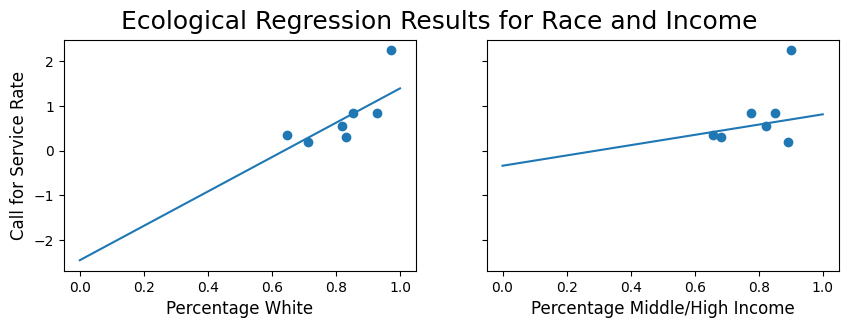

In [52]:
fig, ax = plt.subplots(1,2, figsize = (10,3), sharex = True, sharey = True)
race_slope = m_race * race_goodmans_er.slope_
race_intercept = m_race * race_goodmans_er.intercept_
c_true = C/p
c_fit_race = race_slope * X_race + race_intercept

ax[0].scatter(X_race,c_true)
ax[0].plot([0,1],[race_intercept, race_slope + race_intercept])
ax[0].set_ylabel("Call for Service Rate", fontsize = 12)
ax[0].set_xlabel("Percentage White", fontsize = 12)

pov_slope = m_pov * pov_goodmans_er.slope_
pov_intercept = m_pov * pov_goodmans_er.intercept_
c_fit_pov = pov_slope * X_pov + pov_intercept
ax[1].scatter(X_pov,c_true)
ax[1].plot([0,1],[pov_intercept, pov_slope + pov_intercept])
ax[1].set_xlabel("Percentage Middle/High Income", fontsize = 12)
plt.suptitle("Ecological Regression Results for Race and Income", fontsize = 18)
plt.show()